In [2]:
# You may need to install these packages before proceeding

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install causalgraphicalmodels

In [6]:
conda install python-graphviz

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Admin\Anaconda3

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.1               |   py37haa95532_1         2.9 MB
    graphviz-2.38              |       hfd603c8_2        29.3 MB
    python-graphviz-0.16       |     pyhd3eb1b0_1          20 KB
    ------------------------------------------------------------
                                           Total:        32.2 MB

The following NEW packages will be INSTALLED:

  graphviz           pkgs/main/win-64::graphviz-2.38-hfd603c8_2
  python-graphviz    pkgs/main/noarch::python-graphviz-0.16-pyhd3eb1b0_1

The following packages will be UPDATED:

  conda                                4.9.2-py37haa95532_0 --> 4.10.1-py37haa95532_1




graphviz-2.38        | 29.3 MB   |            |   0% 


Causal Graphical Models
Let us begin with a classical example of a causal system: the sprinker. It is a system of five variable which indicate the conditions on a certain day:

season: indicates which season it is
rain: indicates whether it is raining
sprinkler: indicates whether our sprinkler is on
wet: indicates whether the group is wet
slippery: indicates whether the ground is slippery
We know that when it rains, the ground will become wet, however the making the ground wet doesn't cause it to rain. This is exactly the kind of direct relationship that could be described by a function. In the absence of this actual function, we are left with a set of variables and directed relationships between then. A natural way to represent this structure is a directed graph, specifically a Directed Acyclic Graph. We require the graph to be acyclic to prevent "causal loops".

We can create a causal graphical model of this system by specifying the nodes and edges of this graph:

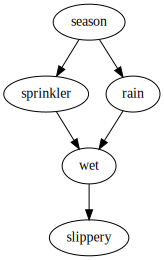

In [1]:

from causalgraphicalmodels import CausalGraphicalModel

sprinkler = CausalGraphicalModel(
    nodes=["season", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("season", "rain"), 
        ("season", "sprinkler"), 
        ("rain", "wet"),
        ("sprinkler", "wet"), 
        ("wet", "slippery")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

This is a Probabilistic Graphical Model description of the system (for more information, I recommend this excellent Coursera Course on probabilistic graphical models): a non-parametric model of the structure which generates data.

Describing a system in the way implies that the joint probability distribution over all variables can be factored in the following way:

P(X)=∏iP(Xi∣PA(Xi))
Where PA(Xi) is the set of parents of the variable Xi, with respect to the graph.

We can get the join probability distribution implied by our causal graphical model using

In [2]:
print(sprinkler.get_distribution())

P(season)P(sprinkler|season)P(rain|season)P(wet|rain,sprinkler)P(slippery|wet)


This factorization of the joint probability distribution in implies certain conditional independence relationships between variables. For example, if we know whether or not the ground is wet, then whether or not it is slippery is independent of the season. In the language of probabilistic graphical models, two variables are conditionally independent given other variables if they are d-separated.

I'm not going to go into a full proof of d-separation, but to get some intuition about how it is calculated, consider the skeleton of our DAG (the graph with the same nodes and edges, but no notion of "direction"). Two variables can only be related if there are paths between them, so we can limit our attention to the paths between variables. If there is only a single edge between the variables, they cannot be conditionally independent.

For paths of three nodes, there are three possible situations, a fork, a chain and a collider, shown below:

Implied conditional Independence Relationship:  [('x3', 'x1', {'x2'})]


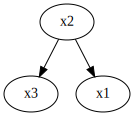

In [3]:
from causalgraphicalmodels.examples import fork, chain, collider

print("Implied conditional Independence Relationship: ", 
      fork.get_all_independence_relationships())
fork.draw()

Implied conditional Independence Relationship:  [('x3', 'x1', {'x2'})]


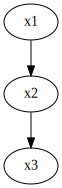

In [4]:
print("Implied conditional Independence Relationship: ", 
      chain.get_all_independence_relationships())
chain.draw()

In the fork and the chain imply the same independence relationships: X1 and X3 are not independent, unless we condition on X2 when they become conditionally independent. (Although I should note they imply very different causal structures: In a chain X1 has causal influence on X3, but in a fork there is no causal influence).

Implied conditional Independence Relationship:  [('x3', 'x1', set())]


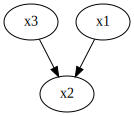

In [5]:
print("Implied conditional Independence Relationship: ", 
      collider.get_all_independence_relationships())
collider.draw()

For the collider, x1 and x3 are independent, unless x2 or any of it's descendants are in the group we condition on. This is sometimes called Berkson's Paradox.

For paths longer then length 3, it turns out we can use the previous results to decide if two nodes are d-separated by examining each three structure along the paths: a path is d-separated if all sets of consecutive 3-nodes are d-separated.

Consider the following path between X1 and X5:

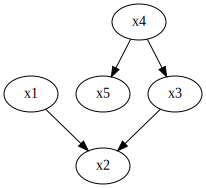

In [6]:
path = CausalGraphicalModel(
    nodes = ["x1", "x2", "x3", "x4", "x5"],
    edges = [("x1", "x2"), ("x3", "x2"), ("x4", "x3"), ("x4", "x5")]
)

path.draw()

If we condition on nothing, they are d-separated because the collider (X1, X2, X3) leaves the path blocked. However, if we condition on X2 or any of it's descendants the path becomes unblocked, because the rest of the path is made up of forks (X3, X4, X5) and chains (X2, X3, X4). If we condition on X2 and X3 the path becomes blocked again because the chain (X2, X3, X4) is blocked.

We can check this with the following code:

In [7]:
print("Are x1 and x5 unconditional independent? {} "
      .format(path.is_d_separated("x1", "x5", {})))

print("Are x1 and x5 conditional independent when conditioning on x2? {} "
      .format(path.is_d_separated("x1", "x5", {"x2"})))

print("Are x1 and x5 conditional independent when conditioning on x2 and x3? {} "
      .format(path.is_d_separated("x1", "x5", {"x2", "x3"})))

Are x1 and x5 unconditional independent? True 
Are x1 and x5 conditional independent when conditioning on x2? False 
Are x1 and x5 conditional independent when conditioning on x2 and x3? True 


We can read off all independence relationships implied by the graph in the sprinkler system using:

In [8]:
sprinkler.get_all_independence_relationships()

[('sprinkler', 'slippery', {'wet'}),
 ('sprinkler', 'slippery', {'season', 'wet'}),
 ('sprinkler', 'slippery', {'rain', 'wet'}),
 ('sprinkler', 'slippery', {'rain', 'season', 'wet'}),
 ('sprinkler', 'rain', {'season'}),
 ('slippery', 'rain', {'wet'}),
 ('slippery', 'rain', {'sprinkler', 'wet'}),
 ('slippery', 'rain', {'season', 'wet'}),
 ('slippery', 'rain', {'season', 'sprinkler', 'wet'}),
 ('slippery', 'season', {'wet'}),
 ('slippery', 'season', {'sprinkler', 'wet'}),
 ('slippery', 'season', {'rain', 'sprinkler'}),
 ('slippery', 'season', {'rain', 'wet'}),
 ('slippery', 'season', {'rain', 'sprinkler', 'wet'}),
 ('wet', 'season', {'rain', 'sprinkler'}),
 ('wet', 'season', {'rain', 'slippery', 'sprinkler'})]

At this point it is worth emphasising that causal graphical models are non-parametric: they do not make any assumptions about the functional form of relationships between variables, only that they exist. Because of this the only testable assumption these models make are the conditional independence relationships between the variables. Unfortunately, testing conditional independence, in the general case, is impossible. Combined with the fact that there are many possible DAGs for even a reasonable number of variables, discovering causal structure from observational data alone is very difficult.

There are still some interesting approaches to identifying causal structure, but for these notes, it is best to think of the main use of causal graphical models as a way of explicitly encoding prior knowledge about the structure of a system, and to use this structure combined with observational data to make predictions about the effect of causal interventions.At this point it is worth emphasising that causal graphical models are non-parametric: they do not make any assumptions about the functional form of relationships between variables, only that they exist. Because of this the only testable assumption these models make are the conditional independence relationships between the variables. Unfortunately, testing conditional independence, in the general case, is impossible. Combined with the fact that there are many possible DAGs for even a reasonable number of variables, discovering causal structure from observational data alone is very difficult.

There are still some interesting approaches to identifying causal structure, but for these notes, it is best to think of the main use of causal graphical models as a way of explicitly encoding prior knowledge about the structure of a system, and to use this structure combined with observational data to make predictions about the effect of causal interventions.